## Setup

In [12]:
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier #Support Vector Machine
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

os.getcwd()
cwd= os.chdir(r"C:\Users\carin\OneDrive\PhD\CGS\SS18\NLP\Exercise2")

## Datasets
For dataset 2 I decided to concatenate the categories from 5 to 2.

In [13]:
def dataset_1():
    dataset = pd.read_csv(r'./fake_or_real_news.csv')
    dataset = dataset.set_index('Unnamed: 0')
    categories = ['FAKE', 'REAL']
    y = dataset.label
    dataset = dataset.drop('label', axis=1)
    XXYY = train_test_split(dataset['text'], y, test_size=0.33, random_state=53)
    X = XXYY[0:2]
    Y = XXYY[2:4]
    return (X, Y, categories)
    

def dataset_2():
    myFiles = glob.glob(r'./*.tsv')
        
    dfs = ()
    for file in myFiles:
        df = pd.read_csv(file, sep='\t', header=None, usecols=[1,2], names=['y', 'claim']) #read-in data
        dfs = dfs + tuple((df,))
    
    for df in dfs:
        df['y'] = df['y'].replace({'half-true':'REAL', 'mostly-true':'REAL', 'barely-true':'REAL', 'pants-fire':'FAKE'}) #label is made to be binary
        
    X = ()
    for df in dfs:
        x = df['claim'] 
        X = X + tuple((x,))
        
    Y = ()
    for df in dfs:
        y = df['y'] 
        Y = Y + tuple((y,))  
        
    categories = ['FAKE', 'REAL']
    return (X, Y, categories)

#make df3
dfs = ()

df = pd.read_csv(r'./fake_or_real_news.csv', skiprows=[0], usecols=[3,2], names=['claim', 'y'])    
dfs = dfs + tuple((df,))

myFiles = glob.glob(r'./*.tsv')

for file in myFiles:
    df = pd.read_csv(file, sep='\t', header=None, usecols = [1,2], names=['y', 'claim'])[['claim', 'y']]
    dfs = dfs + tuple((df,))
    
for df in dfs:
    df['y'] = df['y'].replace({'half-true':'REAL', 'mostly-true':'REAL', 'barely-true':'REAL', 'true':'REAL', 'false':'FAKE', 'pants-fire':'FAKE'}) #label is made to be binary

df3 = pd.concat(dfs, ignore_index=True)
df3.to_csv(r'./df3.csv', encoding = "utf8")

## Vectorizers

In [14]:
def count_V(X, Y):
    count_vectorizer = CountVectorizer(stop_words='english')
    count = ()
    count = count + (count_vectorizer.fit_transform(X[0]),)
    for x in range(1,len(X)):
        count = count + (count_vectorizer.transform(X[x]),)
    return (count)

def tfidf_V(X,Y):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
    tfidf = ()
    tfidf = tfidf + (tfidf_vectorizer.fit_transform(X[0]),)
    for x in range(1,len(X)):
        tfidf = tfidf + (tfidf_vectorizer.transform(X[x]),)
    return (tfidf)

## Models

In [15]:
'Katherine used Passive Aggressive Classifiers, I use Support Vector Machines, which is another linear model'
def model_a(tfidf, Y):
    model_a = SGDClassifier(max_iter=50) #Support Vector Machine
    model_a.fit(tfidf[0], Y[0]) #tfidf, fitting with training data
    pred = ()
    for t in range(len(tfidf)):
        pred = pred + (model_a.predict(tfidf[t]),)
    return pred

'Features are stored in count_vectorizer and tfidf_vectorizer.'
'Changing the max_df and min_df of the TF-IDF vectorizer lead to different features.'
'Katherine used the tfidf vectorizer. I use the count vectorizer:'
def model_b(count, Y):
    model_b = SGDClassifier(max_iter=50) #Support Vector Machine
    model_b.fit(count[0], Y[0]) #count
    pred = ()
    for t in range(len(count)):
        pred = pred + (model_b.predict(count[t]),)
    return pred

## Configurations

In [16]:
kf = StratifiedKFold(n_splits=5, random_state=4222, shuffle=False)

conf = []
acc = []

### Configuration 1
model a + dataset1 + train + test + k-fold cross validation
<br>
<br>
for k-fold cross validation a weighted average is used

In [17]:
df = pd.read_csv(r'./fake_or_real_news.csv')
x = df["text"]
y = df["label"]
categories = ['FAKE', 'REAL']

MCR_train = []
ACC_train = []
MCR_test = []
ACC_test = []

for train_index, test_index in kf.split(x, y):
    X = [None, None]
    Y = [None, None]
    X[0], X[1] = x[train_index], x[test_index]
    Y[0], Y[1]  = y[train_index], y[test_index]

    tfidf = tfidf_V(X, Y)
    pred = model_a(tfidf, Y)
    
    MCR_train.append(precision_recall_fscore_support(Y[0], pred[0], average = "weighted")) #TRAIN
    ACC_train.append(metrics.accuracy_score(Y[0], pred[0], normalize=True, sample_weight=None))
    
    MCR_test.append(precision_recall_fscore_support(Y[1], pred[1], average = "weighted")) #TEST
    ACC_test.append(metrics.accuracy_score(Y[1], pred[1], normalize=True, sample_weight=None))
    
#averages
df = pd.DataFrame(MCR_train, columns=['precision', 'recall', 'f-score', 'support'])
df = df.drop(['support'], axis=1)
se = pd.Series(ACC_train)
df['accuracy'] = se.values
C1_mean_train = pd.Series( df.mean())

df = pd.DataFrame(MCR_test, columns=['precision', 'recall', 'f-score', 'support'])
df = df.drop(['support'], axis=1)
se = pd.Series(ACC_test)
df['accuracy'] = se.values
C1_mean_test = pd.Series( df.mean())

### Configuration 2
model b + dataset 2 + train + validation + test

In [18]:
X, Y, categories = dataset_2()
count = count_V(X, Y)
pred = model_b(count, Y)
conf.append(precision_recall_fscore_support(Y[0], pred[0], average = "weighted")) #TRAIN
acc.append(metrics.accuracy_score(Y[0], pred[0], normalize=True, sample_weight=None))

conf.append(precision_recall_fscore_support(Y[1], pred[1], average = "weighted")) #TEST
acc.append(metrics.accuracy_score(Y[1], pred[1], normalize=True, sample_weight=None))

conf.append(precision_recall_fscore_support(Y[2], pred[2], average = "weighted")) #VALID
acc.append(metrics.accuracy_score(Y[2], pred[2], normalize=True, sample_weight=None))

### Configuration 3
model a + dataset 2 + test 
<br>
model b + dataset 1 + test

In [19]:
X, Y, categories = dataset_2()
tfidf = tfidf_V(X, Y)
pred = model_a(tfidf, Y)
conf.append(precision_recall_fscore_support(Y[1], pred[1], average = "weighted")) #TEST
acc.append(metrics.accuracy_score(Y[1], pred[1], normalize=True, sample_weight=None))

X, Y, categories = dataset_1()
count = count_V(X, Y)
pred = model_b(count, Y)
conf.append(precision_recall_fscore_support(Y[1], pred[1], average = "weighted")) #TEST
acc.append(metrics.accuracy_score(Y[1], pred[1], normalize=True, sample_weight=None))


### Configuration 4
model a + dataset 3 + train + test + k-fold cross validation

In [20]:
df = pd.read_csv(r'./df3.csv', skiprows=[0], usecols=[1,2], names=['claim', 'y'])    
x = df["claim"]
y = df["y"]
categories = ['FAKE', 'REAL']


MCR_train = []
ACC_train = []
MCR_test = []
ACC_test = []

for train_index, test_index in kf.split(x, y):
    X = [None, None]
    Y = [None, None]
    X[0], X[1] = x[train_index], x[test_index]
    Y[0], Y[1]  = y[train_index], y[test_index]

    tfidf = tfidf_V(X, Y)
    pred = model_a(tfidf, Y)
    
    MCR_train.append(precision_recall_fscore_support(Y[0], pred[0], average = "weighted")) #TRAIN
    ACC_train.append(metrics.accuracy_score(Y[0], pred[0], normalize=True, sample_weight=None))
    
    MCR_test.append(precision_recall_fscore_support(Y[1], pred[1], average = "weighted")) #TEST
    ACC_test.append(metrics.accuracy_score(Y[1], pred[1], normalize=True, sample_weight=None))
    
#averages
df = pd.DataFrame(MCR_train, columns=['precision', 'recall', 'f-score', 'support'])
df = df.drop(['support'], axis=1)
se = pd.Series(ACC_train)
df['accuracy'] = se.values
C4_mean_train = pd.Series(df.mean())

df = pd.DataFrame(MCR_test, columns=['precision', 'recall', 'f-score', 'support'])
df = df.drop(['support'], axis=1)
se = pd.Series(ACC_test)
df['accuracy'] = se.values
C4_mean_test= pd.Series(df.mean())

### Plot

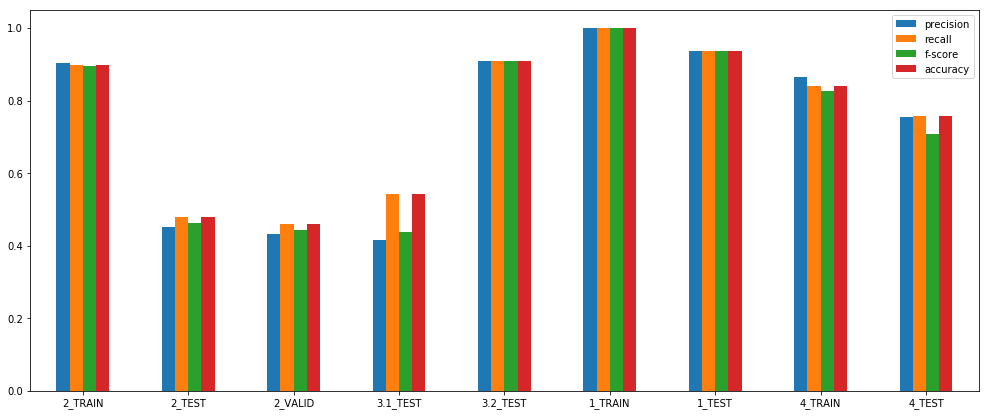

In [21]:
%matplotlib inline
import matplotlib

df = pd.DataFrame(conf, columns=['precision', 'recall', 'f-score', 'support'], index = ['2_TRAIN','2_TEST','2_VALID','3.1_TEST','3.2_TEST'])
df = df.drop(['support'], axis=1)
se = pd.Series(acc)
df['accuracy'] = se.values

df.loc['1_TRAIN'] = C1_mean_train
df.loc['1_TEST'] = C1_mean_test
df.loc['4_TRAIN'] = C4_mean_train
df.loc['4_TEST'] = C4_mean_test

df.plot(kind = 'bar', rot=0, figsize= (17,7) )

Saving MetaData as RDF

In [1]:
from rdflib import Namespace, Graph, Literal
from rdflib.namespace import FOAF, OWL, XSD, RDFS, DCTERMS, DOAP, DC, RDF

prov = Namespace('http://www.w3.org/ns/prov#')
dcat = Namespace('http://www.w3.org/ns/dcat#')
mexalgo = Namespace('http://mex.aksw.org/mex-algo#')
mexperf = Namespace('http://mex.aksw.org/mex-perf#')
mexcore = Namespace('http://mex.aksw.org/mex-core#')
this = Namespace('http://mex.aksw.org/examples/')

g = Graph()
# Create Binding
g.bind('dct',DCTERMS)
g.bind('owl',OWL)
g.bind('foaf',FOAF)
g.bind('xsd', XSD)
g.bind('rdfs', RDFS)
g.bind('doap', DOAP)
g.bind('dc', DC)
g.bind('prov', prov)
g.bind('dcat', dcat)
g.bind('mexalgo',mexalgo)
g.bind('mexperf',mexperf)
g.bind('mexcore',mexcore)
g.bind('this',this)

g.add((this.hausladen_task2,RDF.type, mexcore.Experiment))
g.add((this.hausladen_task2,RDF.type, mexcore.ApplicationContext))
g.add((this.hausladen_task2,RDFS.label, Literal('7344284')))
g.add((this.hausladen_task2,DCTERMS.date, Literal('2018-06-02',datatype=XSD.date)))
g.add((this.hausladen_task2,FOAF.givenName, Literal('Carina')))
g.add((this.hausladen_task2,FOAF.mbox, Literal('hauslaca@gmail.com')))

#Configuration-1
g.add((this.configuration1,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration1,prov.used, this.model1))
g.add((this.configuration1,prov.wasStartedBy, this.khan_task2))

#Configuration-2
g.add((this.configuration2,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration2,prov.used, this.model2))
g.add((this.configuration2,prov.wasStartedBy, this.hausladen_task2))

#Configuration-3
g.add((this.configuration3,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration3,prov.used, this.model2))
g.add((this.configuration3,prov.used, this.model1))
g.add((this.configuration3,prov.wasStartedBy, this.hausladen_task2))

#Configuration-4
g.add((this.configuration4,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration4,prov.used, this.model4))
g.add((this.configuration4,prov.wasStartedBy, this.hausladen_task2))

g.add((this.test,RDF.type,mexcore.Test))
g.add((this.test,RDFS.label,Literal('Test')))

g.add((this.hyerparameter_model1,RDF.type,mexalgo.HyperParameterCollection))
g.add((this.hyerparameter1,RDFS.label,Literal('HyperParameterCollection')))
g.add((this.hyerparameter_model1,prov.hadMember,this.hyerparameter1))

g.add((this.hyerparameter_model2,RDF.type,mexalgo.HyperParameterCollection))
g.add((this.hyerparameter_model2,RDFS.label,Literal('HyperParameterCollection')))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter2))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter3))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter4))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter5))


g.add((this.hyerparameter_model4,RDF.type,mexalgo.HyperParameterCollection))
g.add((this.hyerparameter_model4,RDFS.label,Literal('HyperParameterCollection')))
g.add((this.hyerparameter_model4,prov.hadMember,this.hyerparameter6))
g.add((this.hyerparameter_model4,prov.hadMember,this.hyerparameter7))
g.add((this.hyerparameter_model4,prov.hadMember,this.hyerparameter8))

g.add((this.hyerparameter1,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter1,RDFS.label, Literal('alpha')))
g.add((this.hyerparameter1,DCTERMS.identifier, Literal('alpha')))
g.add((this.hyerparameter1,prov.value, Literal('1.0',datatype=XSD.float)))

g.add((this.hyerparameter2,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter2,RDFS.label, Literal('min_samples_split')))
g.add((this.hyerparameter2,DCTERMS.identifier, Literal('min_samples_split')))
g.add((this.hyerparameter2,prov.value, Literal('2',datatype=XSD.integer)))

g.add((this.hyerparameter3,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter3,RDFS.label, Literal('min_samples_leaf')))
g.add((this.hyerparameter3,DCTERMS.identifier, Literal('min_samples_leaf')))
g.add((this.hyerparameter3,prov.value, Literal('1',datatype=XSD.integer)))

g.add((this.hyerparameter4,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter4,RDFS.label, Literal('splitter')))
g.add((this.hyerparameter4,DCTERMS.identifier, Literal('splitter')))
g.add((this.hyerparameter4,prov.value, Literal('best')))

g.add((this.hyerparameter5,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter5,RDFS.label, Literal('criterion')))
g.add((this.hyerparameter5,DCTERMS.identifier, Literal('criterion')))
g.add((this.hyerparameter5,prov.value, Literal('gini')))

g.add((this.hyerparameter6,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter6,RDFS.label, Literal('max_iter')))
g.add((this.hyerparameter6,DCTERMS.identifier, Literal('max_iter')))
g.add((this.hyerparameter6,prov.value, Literal('100',datatype=XSD.integer)))

g.add((this.hyerparameter7,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter7,RDFS.label, Literal('penalty')))
g.add((this.hyerparameter7,DCTERMS.identifier, Literal('penalty')))
g.add((this.hyerparameter7,prov.value, Literal('l2')))


g.add((this.hyerparameter8,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter8,RDFS.label, Literal('C')))
g.add((this.hyerparameter8,DCTERMS.identifier, Literal('C')))
g.add((this.hyerparameter8,prov.value, Literal('1.0',datatype=XSD.float)))

g.add((this.dataset1,RDF.type,mexcore.Dataset))
g.add((this.dataset1,RDFS.label,Literal('Fake-News')))
g.add((this.dataset1,DCTERMS.landingPage,Literal('https://github.com/GeorgeMcIntire/fake_real_news_dataset')))

g.add((this.dataset2,RDF.type,mexcore.Dataset))
g.add((this.dataset2,RDFS.label,Literal('Liar-Liar')))
g.add((this.dataset2,DCTERMS.landingPage,Literal('https://www.cs.ucsb.edu/william/data/liar_dataset.zip')))

g.add((this.dataset3,RDF.type,mexcore.Dataset))
g.add((this.dataset3,RDFS.label,Literal('Fake-News+Liar-Liar')))
g.add((this.dataset3,DCTERMS.landingPage,Literal('https://www.cs.ucsb.edu/william/data/liar_dataset.zip')))
g.add((this.dataset3,DCTERMS.landingPage,Literal('https://github.com/GeorgeMcIntire/fake_real_news_dataset')))


g.add((this.cross_validation,RDF.type,mexcore.crossValidation))
g.add((this.cross_validation,RDFS.label,Literal('cross validation')))
g.add((this.cross_validation,mexcore.folds,Literal('5',datatype=XSD.integer)))
g.add((this.cross_validation,mexcore.random_state,Literal('4222',datatype=XSD.integer)))

g.add((this.execution1,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution1,prov.generated,this.performance_measures1))
g.add((this.execution1,prov.used,this.test))
g.add((this.execution1,prov.used,this.hyerparameter_model1))
g.add((this.execution1,prov.used,this.model1))

g.add((this.execution2,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution2,prov.generated,this.performance_measures2))
g.add((this.execution2,prov.used,this.test))
g.add((this.execution2,prov.used,this.hyerparameter_model2))
g.add((this.execution2,prov.used,this.model2))

g.add((this.execution3,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution3,prov.generated,this.performance_measures3))
g.add((this.execution3,prov.used,this.test))
g.add((this.execution3,prov.used,this.model2))
g.add((this.execution3,prov.used,this.model3))

g.add((this.execution4,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution4,prov.generated,this.performance_measures4))
g.add((this.execution4,prov.used,this.test))
g.add((this.execution4,prov.used,this.hyerparameter_model4))
g.add((this.execution4,prov.used,this.model4))

g.add((this.performance_measures1,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures1,mexperf.precision,Literal('0.93',datatype=XSD.float)))
g.add((this.performance_measures1,mexperf.recall,Literal('0.93',datatype=XSD.float)))
g.add((this.performance_measures1,mexperf.accuracy,Literal('0.93',datatype=XSD.float)))
g.add((this.performance_measures1,prov.wasGeneratedBy,this.execution1))

g.add((this.performance_measures2,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures2,mexperf.precision,Literal('0.47',datatype=XSD.float)))
g.add((this.performance_measures2,mexperf.recall,Literal('0.44',datatype=XSD.float)))
g.add((this.performance_measures2,mexperf.accuracy,Literal('0.47',datatype=XSD.float)))
g.add((this.performance_measures2,prov.wasGeneratedBy,this.execution2))

g.add((this.performance_measures3,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures3,mexperf.precision,Literal('0.91',datatype=XSD.float)))
g.add((this.performance_measures3,mexperf.recall,Literal('0.91',datatype=XSD.float)))
g.add((this.performance_measures3,mexperf.accuracy,Literal('0.91',datatype=XSD.float)))
g.add((this.performance_measures3,prov.wasGeneratedBy,this.execution3))


g.add((this.performance_measures4,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures4,mexperf.precision,Literal('0.82',datatype=XSD.float)))
g.add((this.performance_measures4,mexperf.recall,Literal('0.83',datatype=XSD.float)))
g.add((this.performance_measures4,mexperf.accuracy,Literal('0.82',datatype=XSD.float)))
g.add((this.performance_measures4,prov.wasGeneratedBy,this.execution4))


g.add((this.model1,RDF.type,mexalgo.Algorithm))
g.add((this.model1,RDFS.label,Literal('MultinomialNB')))
g.add((this.model1,DCTERMS.identifier,Literal('MultinomialNB')))
g.add((this.model1,mexalgo.hasHyperParameter,this.hyerparameter1))

g.add((this.model2,RDF.type,mexalgo.Algorithm))
g.add((this.model2,RDFS.label,Literal('DecisionTree')))
g.add((this.model2,DCTERMS.identifier,Literal('DecisionTree')))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter2))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter3))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter4))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter5))

g.add((this.model4,RDF.type,mexalgo.Algorithm))
g.add((this.model4,RDFS.label,Literal('LogisticRegression')))
g.add((this.model4,DCTERMS.identifier,Literal('LogisticRegression')))
g.add((this.model4,mexalgo.hasHyperParameter,this.hyerparameter6))
g.add((this.model4,mexalgo.hasHyperParameter,this.hyerparameter7))
g.add((this.model4,mexalgo.hasHyperParameter,this.hyerparameter8))

with open('task2_metadata.ttl','wb') as f:
    f.write(g.serialize(format='turtle'))
